In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy import wcs
import imgscl
# from scipy.misc import bytescale
import pandas as pd
import copy
from scipy import ndimage
from skimage.feature import register_translation
from scipy.ndimage import fourier_shift

In [2]:
# ----- Loading the original HST image ----- #

# kpc20 = 20.0/4.370/0.03
ifu_h = 5.0 / 0.05
ifu_w = 7.0 / 0.05
# seeing = 0.7 / 0.05

# ----- Directories ----- #
dir_fig = '/data/jlee/DATA/Gemini/Programs/GN-2019A-Q-215/analysis/diagram/linefits/'
diI = '/data/jlee/DATA/HLA/McPartland+16/MACS1752/JFG2/Phot/'
diG = '/data/jlee/DATA/Gemini/Programs/GN-2019A-Q-215/redux4_700/'


# ----- Reading FITS file ----- #
hdr1 = fits.getheader(diG+'cstxeqxbrgN20190611S0257_3D.fits', ext=0)
gra, gdec, gpa = hdr1['RA'], hdr1['DEC'], hdr1['PA']
print(gpa)


# ----- Reading FITS images and creating RGB data ----- #
img606 = fits.getdata(diI+'606_ori.fits', ext=0)
img814 = fits.getdata(diI+'814_ori.fits', ext=0)

cimg = np.zeros((img814.shape[0], img814.shape[1], 3), dtype=float)
cimg[:,:,0] = imgscl.linear(0.5*img814, scale_min=-0.02, scale_max=0.075)   # R
cimg[:,:,1] = imgscl.linear(0.5*(img606+img814), scale_min=-0.02, scale_max=0.15)   # G
cimg[:,:,2] = imgscl.linear(0.5*img606, scale_min=-0.02, scale_max=0.075)   # B


# ----- WCS to XY ----- #
h = fits.getheader(diI+'606_ori.fits', ext=0)
w = wcs.WCS(h)
px, py = w.wcs_world2pix(gra, gdec, 1)

85.0


In [3]:
# ----- Reading ellipse region file ----- #
from reg_saoimage import read_region
regionfile = "HST_boundary_1sig.reg"
x0, y0, a, b, pa = read_region(regionfile, regtype='ellipse')
x0, y0, a, b, pa = x0[0], y0[0], a[0], b[0], pa[0]

from matplotlib.patches import Ellipse as ell

<IPython.core.display.Javascript object>


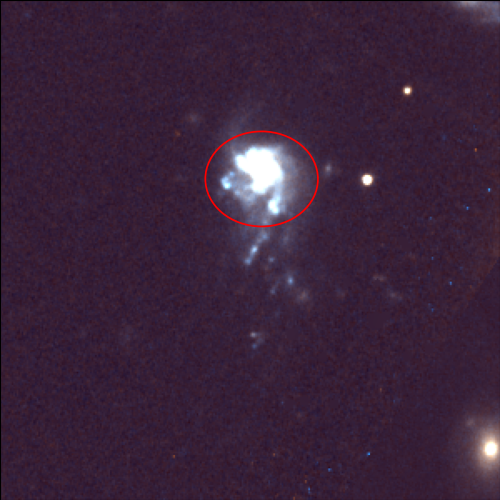

(300, 300, 3)

In [4]:
# ----- Loading the original HST image ----- #

# ----- Figure 1 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #

# Color map
rth = 150.0
img = cimg[int(np.round(py)-1-rth):int(np.round(py)-1+rth),
           int(np.round(px)-1-rth):int(np.round(px)-1+rth),:]

ax1.imshow(img, aspect='equal', origin='lower')

x1, y1 = x0-(int(np.round(px)-rth)), y0-(int(np.round(py)-rth))
e1 = ell((x1, y1), width=2*a, height=2*b, angle=pa,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e1)

img.shape

In [5]:
# ----- Rotating the image ----- #
rotated_img = ndimage.rotate(img, gpa)
rotated_img.shape

(325, 325, 3)

<IPython.core.display.Javascript object>


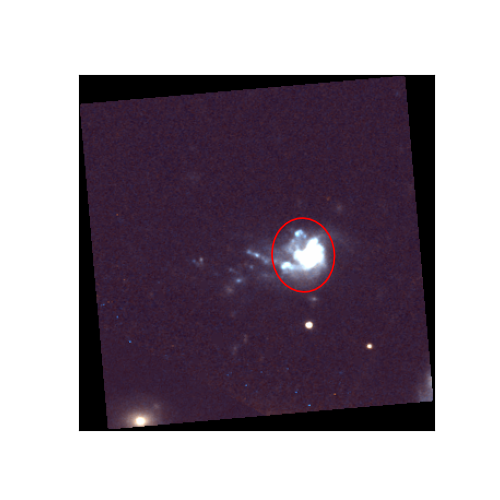

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
# ----- Showing the rotated image ----- #

# ----- Figure 2 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(rotated_img, aspect='equal', origin='lower')

t1 = np.arctan(y1/x1)*180./np.pi
d1 = np.sqrt(x1**2 + y1**2)

if ((gpa >= 0.) & (gpa < 90.)):
    x2_0 = 0.
    y2_0 = img.shape[0]*np.sin(gpa*np.pi/180.)
if ((gpa >= 90.) & (gpa < 180.)):
    x2_0 = -img.shape[0]*np.cos(gpa*np.pi/180.)
    y2_0 = -img.shape[0]*(np.sin(gpa*np.pi/180.)+np.cos(gpa*np.pi/180.))
if ((gpa >= 180.) & (gpa < 270.)):
    x2_0 = -img.shape[0]*(np.sin(gpa*np.pi/180.)+np.cos(gpa*np.pi/180.))
    y2_0 = -img.shape[0]*np.sin(gpa*np.pi/180.)
if ((gpa >= 270.) & (gpa < 360.)):
    x2_0 = img.shape[0]*np.cos(gpa*np.pi/180.)
    y2_0 = 0.
x2 = x2_0 + d1*np.cos((t1-gpa)*np.pi/180.) 
y2 = y2_0 + d1*np.sin((t1-gpa)*np.pi/180.)

pa2 = pa-gpa

e2 = ell((x2, y2),
         width=2*a, height=2*b, angle=pa2,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e2)

plt.tight_layout()

In [7]:
# ----- Background values ----- #
m0, m1, m2 = np.nanmean(img[210:290, 20:100], axis=(0,1))
s0, s1, s2 = np.std(img[210:290, 20:100], axis=(0,1))
print(m0, m1, m2)
print(s0, s1, s2)

0.20951738861957986 0.11588798914814764 0.2083874340665791
0.01695511834796286 0.014092147474049589 0.019435498293063975


In [8]:
# ----- Putting pixel values to no-signal pixels ----- #
rimg = copy.deepcopy(rotated_img)
no_sign = (rimg == [0., 0., 0.])
no_sign_idx = np.argwhere(no_sign)

for i in np.arange(no_sign_idx.shape[0]):
    rimg[no_sign_idx[i,0], no_sign_idx[i,1], :] = np.random.normal([m0, m1, m2], [s0, s1, s2])

rimg.shape

(325, 325, 3)

<IPython.core.display.Javascript object>


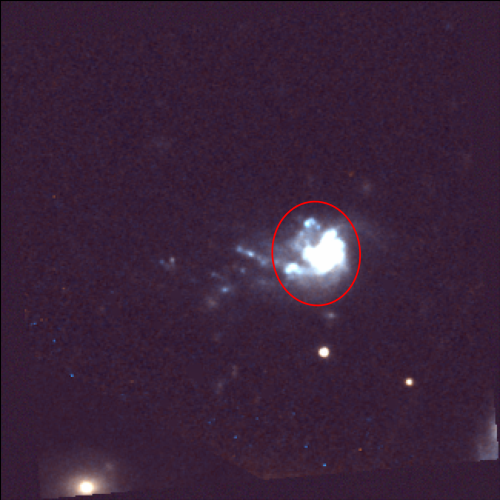

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [9]:
# ----- Showing the created image ----- #

# ----- Figure 3 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(rimg, aspect='equal', origin='lower')

e2 = ell((x2, y2),
         width=2*a, height=2*b, angle=pa2,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e2)

# plt.tight_layout()

In [10]:
# ----- Reading H alpha flux map ----- #
dir_Ha = '/data/jlee/DATA/Gemini/Programs/GN-2019A-Q-215/analysis/lines2/Halpha/'
fits.open(dir_Ha+'flux_2D.fits').info()

Ha_flx = fits.getdata(dir_Ha+'flux_2D.fits', ext=0)
Ha_flx.shape
Ha_snr = fits.getdata(dir_Ha+'snr_2D.fits', ext=0)
Ha_sig = fits.getdata(dir_Ha+'sigma_2D.fits', ext=0)
Ha_rchisq = fits.getdata(dir_Ha+'rchisq_2D.fits', ext=0)

# snr_cnd = (Ha_snr < 3.0)
# # sig_cnd = (Ha_sig < lsig_llim)
# rchi25, rchi50, rchi75 = np.percentile(Ha_rchisq[Ha_rchisq > 0.], [25.0, 50.0, 75.0])
# rchisq_cnd = (Ha_rchisq >= rchi50)
# flx25, flx50, flx75 = np.percentile(Ha_flx[Ha_flx > 0.], [25.0, 50.0, 75.0])
# flx_cnd = (Ha_flx <= flx50)
# zero_cnd = (snr_cnd | rchisq_cnd | flx_cnd)
# Ha_flx[zero_cnd] = 0.

Filename: /data/jlee/DATA/Gemini/Programs/GN-2019A-Q-215/analysis/lines2/Halpha/flux_2D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (68, 49)   float64   


In [11]:
# ----- Making cutout image for 2x2 binning ----- #
hstimg = rimg[int(0.5*(rimg.shape[0]-1)-Ha_flx.shape[0]):int(0.5*(rimg.shape[0]-1)+Ha_flx.shape[0]),
              int(0.5*(rimg.shape[1]-1)-Ha_flx.shape[1]):int(0.5*(rimg.shape[1]-1)+Ha_flx.shape[1]), :]
hstimg.shape

(98, 136, 3)

<IPython.core.display.Javascript object>


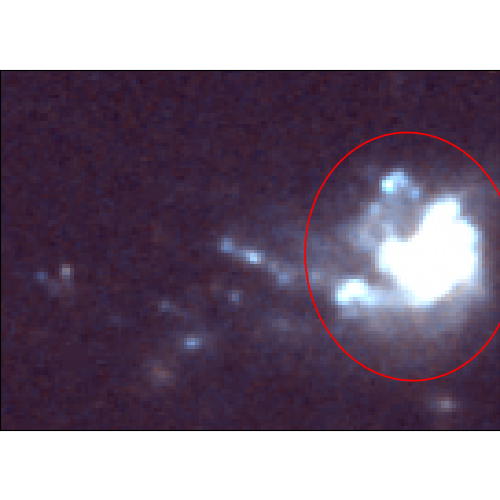

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [12]:
# ----- Showing the cutout HST image ----- #

# ----- Figure 4 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(hstimg, aspect='equal', origin='lower')

x3 = x2-(int(0.5*(rimg.shape[1]-1)-Ha_flx.shape[1]))
y3 = y2-(int(0.5*(rimg.shape[0]-1)-Ha_flx.shape[0]))
pa3 = pa2
e3 = ell((x3, y3),
         width=2*a, height=2*b, angle=pa3,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e3)

# plt.tight_layout()

In [13]:
# ----- 2x2 binning ----- #
bin_nx, bin_ny = 2, 2

hstimg_binned = np.zeros((int(hstimg.shape[0]/bin_ny), int(hstimg.shape[1]/bin_nx), hstimg.shape[2]))

for y in np.arange(int(hstimg.shape[0]/bin_ny)):
    for x in np.arange(int(hstimg.shape[1]/bin_nx)):
        hstimg_binned[y, x, :] = np.mean(hstimg[bin_ny*y:bin_ny*(y+1), bin_nx*x:bin_nx*(x+1), :], axis=(0,1))

hstimg_binned.shape

(49, 68, 3)

<IPython.core.display.Javascript object>


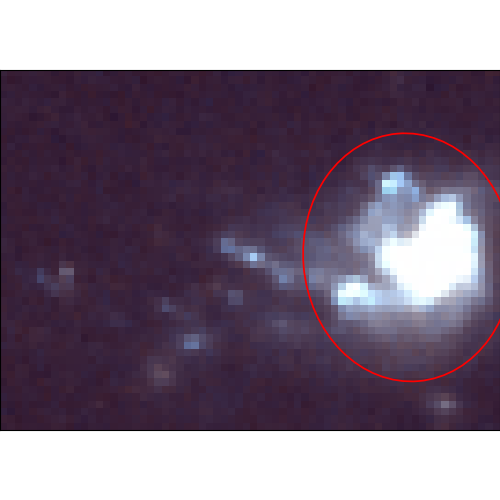

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
# ----- Showing the binned image ----- #

# ----- Figure 5 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(hstimg_binned, aspect='equal', origin='lower')

x4 = x3 // 2 
y4 = y3 // 2
pa4 = pa3
e4 = ell((x4, y4),
         width=a, height=b, angle=pa4,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e4)

In [15]:
# ----- Making the 2D image ----- #
hstimg_2D = np.sum(hstimg_binned, axis=2)
hstimg_2D.shape

(49, 68)

<IPython.core.display.Javascript object>


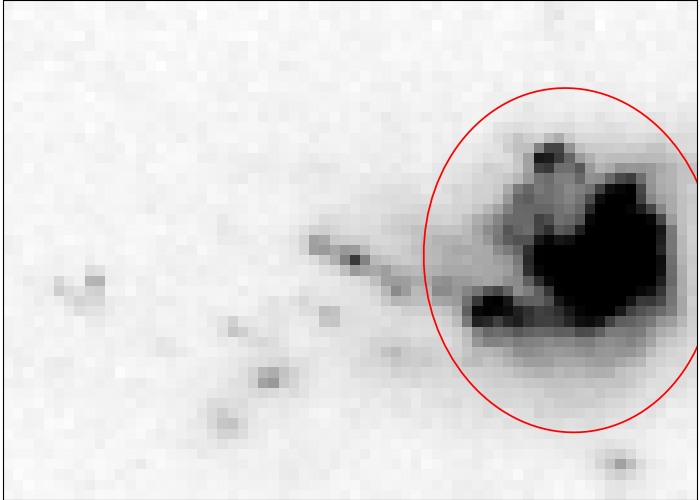

In [16]:
# ----- Showing the binned image ----- #

# ----- Figure 6 ----- #
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(hstimg_2D, aspect='equal', cmap='gray_r', origin='lower')

e4 = ell((x4, y4),
         width=a, height=b, angle=pa4,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e4)

<IPython.core.display.Javascript object>


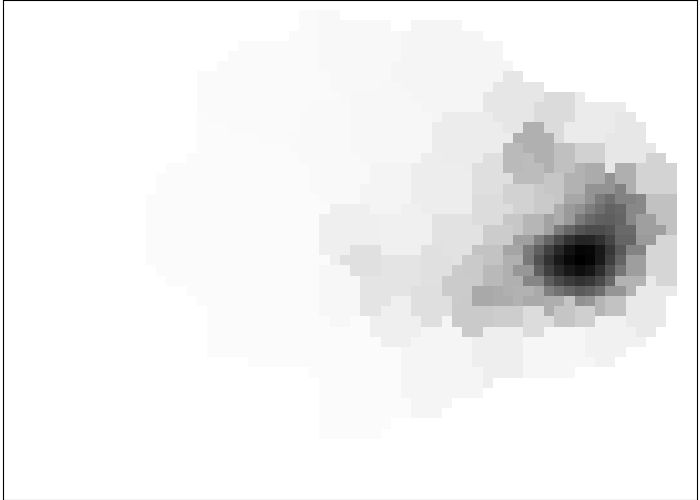

In [17]:
# ----- Showing the flux map ----- #

# ----- Figure 6 ----- #
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(np.flip(Ha_flx, axis=0), aspect='equal', cmap='gray_r', origin='lower')

# e4 = ell((x4, y4),
#          width=a, height=b, angle=pa4,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e4)

In [18]:
# ----- Running the 2D correlation ----- #
shifted, error, diffphase = register_translation(np.flip(Ha_flx, axis=0), hstimg_2D, 100)
corr_hstimg_binned = ndimage.shift(hstimg_binned, shift=(shifted[0], shifted[1], 0), mode='nearest')
shifted

/home/jlee/anaconda3/lib/python3.7/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


array([ 2.01, -1.57])

In [19]:
hstimg_binned.shape

(49, 68, 3)

<IPython.core.display.Javascript object>


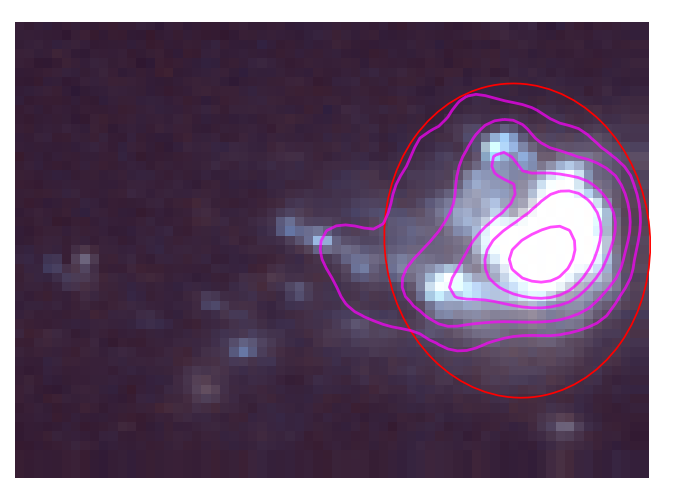

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [20]:
# ----- Figure 1 ----- #
fig1 = plt.figure(figsize=(7,5))
ax1 = plt.subplot(1, 1, 1, adjustable='box')
# ax2 = plt.subplot(2, 1, 2, adjustable='box')

ax1.imshow(corr_hstimg_binned, aspect='equal', origin='lower')
ax1.set_axis_off()

flx_data = copy.deepcopy(Ha_flx)
# flx_data[:, :20] = 0.0
sflx = ndimage.gaussian_filter(flx_data, sigma=(1.5,1.5), order=0)

sig = np.std(sflx[sflx > 0.])
levels = [0.5*sig, 1.*sig, 2.*sig, 3.*sig, 5.*sig, 7.*sig]
lws = tuple(np.repeat(2.0, len(levels)-1)) ; cs = tuple(['magenta']*(len(levels)-1))

Y_coord = np.arange(corr_hstimg_binned.shape[0], step=1)
X_coord = np.arange(corr_hstimg_binned.shape[1], step=1)

ax1.contour(X_coord, Y_coord[::-1], sflx, levels=levels, linewidths=lws, colors=cs, alpha=0.7)
# ax2.set_axis_off()

# ax2.imshow(Ha_flx, aspect='equal', vmin=v_low, vmax=v_high, cmap='gray_r', origin='lower')
# ax2.set_axis_off()

x5, y5, pa5 = x4+shifted[1], y4+shifted[0], pa4
e5 = ell((x5, y5),
         width=a, height=b, angle=pa5,
         fill=False, color='red', linestyle='-', linewidth=1.25)
ax1.add_patch(e5)

plt.tight_layout()

In [21]:
sflx.shape

(49, 68)

In [22]:
sflx.shape

(49, 68)

In [23]:
X_coord.shape, Y_coord[::-1].shape

((68,), (49,))

In [24]:
f = open("HST_boundary_1sig_transformed.reg", "w")
f.write(f"ellipse({x5+1:.3f},{(corr_hstimg_binned.shape[0]-y5)+1:.3f},{0.5*a:.3f},{0.5*b:.3f},{pa5:.3f})")
f.close()

In [25]:
Y_coord = 0.1*(np.arange(hstimg_2D.shape[0], step=1)-hstimg_2D.shape[0]/2)
X_coord = 0.1*(np.arange(hstimg_2D.shape[1], step=1)-hstimg_2D.shape[1]/2)

In [26]:
X_coord.shape, Y_coord.shape

((68,), (49,))

In [27]:
hstimg_2D.shape

(49, 68)

In [28]:
X_coord

array([-3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4,
       -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3,
       -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,
       -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
        1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3])

In [29]:
corr_hstimg_binned.shape

(49, 68, 3)

In [30]:
hstimg.shape

(98, 136, 3)

In [31]:
np.arange(-3.4, 3.4, step=0.1)

array([-3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
       -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
       -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
       -2.20000000e+00, -2.10000000e+00, -2.00000000e+00, -1.90000000e+00,
       -1.80000000e+00, -1.70000000e+00, -1.60000000e+00, -1.50000000e+00,
       -1.40000000e+00, -1.30000000e+00, -1.20000000e+00, -1.10000000e+00,
       -1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01,  3.10862447e-15,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,
        1.80000000e+00,  

In [32]:
np.arange(-2.45, 2.45, step=0.1)

array([-2.45, -2.35, -2.25, -2.15, -2.05, -1.95, -1.85, -1.75, -1.65,
       -1.55, -1.45, -1.35, -1.25, -1.15, -1.05, -0.95, -0.85, -0.75,
       -0.65, -0.55, -0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,
        0.25,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,  0.95,  1.05,
        1.15,  1.25,  1.35,  1.45,  1.55,  1.65,  1.75,  1.85,  1.95,
        2.05,  2.15,  2.25,  2.35])